# Lab 7 - Support Vector Machines

### (0) Import necessary packages and load data

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

df = pd.read_csv('WBC.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,Sample
0,7.705763,0.991449,0.023529,41.733333,1.048193,43.5,5,68.713823,0.781410,0.869809,41.605769,5.0,0.999950,50.6,11,56.8,9,5,0.000000,WBC
1,296.676531,3.069244,0.515789,55.275000,3.130435,108.0,155,271.802401,0.885943,0.820493,56.551683,5.0,0.893470,76.3,8,668.3,9,25,0.037783,WBC
2,537.484884,1.001452,0.058824,42.800000,1.125000,40.5,280,75.633843,0.843340,0.835149,42.076923,5.0,0.999243,50.5,7,36.6,11,3,0.000000,WBC
3,701.235607,1.130061,0.107527,46.266667,1.240964,51.5,365,90.187681,0.705554,0.846169,47.645833,5.0,0.999204,60.4,6,62.7,7,11,0.021176,WBC
4,720.500015,0.995128,0.023256,39.875000,1.047619,44.0,375,65.618147,0.847418,0.831938,44.894231,4.5,0.989088,73.4,9,40.5,8,7,0.000000,WBC


### (1) Choose any two variables and plot them against cell identity (in color). Do you see clear separation of these classes? What does this tell you about whether or not you can classify the cells of differing type?

In [2]:
# Drop out the cell-type labels
cellData = df.drop('Sample', axis=1) # drop off last column

# Get the cell types as strings
cellTypes = set(df['Sample'])

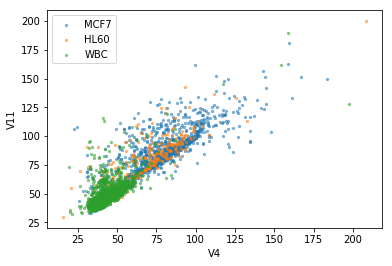

In [3]:
# Get bool mask for each cell type
WBC_bool = df.Sample=='WBC'
MCF7_bool = df.Sample=='MCF7'
HL60_bool = df.Sample=='HL60'

# Get indices for each cell type
WBC_indcs = (df.Sample=='WBC').astype(int)
HL60_indcs = (df.Sample=='HL60').astype(int)
MCF7_indcs = (df.Sample=='MCF7').astype(int)

# Plot
for indx in list(cellTypes):
    cellTypeIndx = df['Sample']==indx
    plt.scatter(df.loc[cellTypeIndx, 'V4'], df.loc[cellTypeIndx, 'V11'], s=5, alpha=0.5)
plt.xlabel('V4')
plt.ylabel('V11')
plt.legend(cellTypes);

The separation of these classes are not clear; it would be difficult to classify cells of differing type.

### (2) Use principal components analysis to visualize the variation in each variable. Plot the first two principal components against the cell type. Do you see better separation in this case? What does this tell you about your ability to distinguish the cell types?

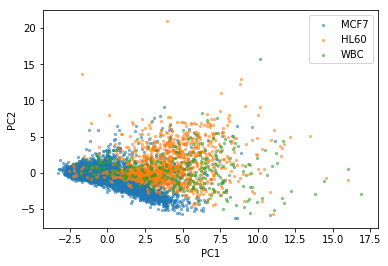

In [4]:
# Create instance of PCA
pca = PCA()

# Convert dataframe to matrix
X_data = cellData.as_matrix()

# Normalize the data first
X_datScale = scale(X_data)

X_PCs = pca.fit_transform(X_datScale)

# Plot
for indx in [WBC_bool, MCF7_bool, HL60_bool]:
    plt.scatter(X_PCs[indx, 0], X_PCs[indx, 1], s=5, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(cellTypes);

# Explained variance
# print(pca.explained_variance_ratio_)
# print(sum(pca.explained_variance_ratio_[0:12]))

### (3) How does partial least squares fare in desciminating cancer and non-cancer cells (make cancer=1 and non-cancer=0)?

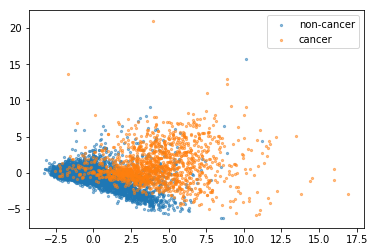

In [5]:
# Create instance of PLSR
PLS = PLSRegression(n_components=12, max_iter=1000)

# Fit the data
xSc, ySc = PLS.fit_transform(X_data, WBC_bool)

# Plot
for indx in [WBC_bool, ~WBC_bool]:
    plt.scatter(X_PCs[indx, 0], X_PCs[indx, 1], s=5, alpha=0.5)
plt.legend(['non-cancer', 'cancer']);

### (4) Setup a support vector machine classifier (with linear kernel) to distinguish cancer and non-cancer. Evaluate how well this performs.

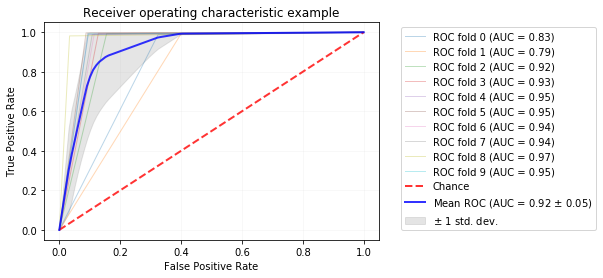

In [6]:
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Set up Stratified K-folds cross validation
cv = StratifiedKFold(n_splits=10)
mean_fpr = np.linspace(0, 1, 100)
svm_L = svm.LinearSVC()
tprs, aucs = [],[]
i = 0

# Cross-validate
for train, test in cv.split(X_PCs, WBC_bool):
    X = X_PCs
    y = WBC_bool
    model = svm_L.fit(X[train], y[train])
    probs = model.predict(X[test])
    # Compute ROC curve and area the curve
    
    # False Positive Rate, True Positive Rate, Thresholds
    FPR, TPR, thresholds = roc_curve(y[test], probs)
    tprs.append(interp(mean_fpr, FPR, TPR))
    tprs[-1][0] = 0.0
    roc_auc = auc(FPR, TPR)
    aucs.append(roc_auc)
    plt.plot(FPR, TPR, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i +=1

# Plot Chance line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

# Plot TPR and AUC means
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

# Shade 1 std. dev.
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(alpha=0.1)

### (5) Choose and justify your selection of a different kernel to use in SVM classification.

A polynomial kernel will be used for the SVM classification. The justification is that from the two randomly chosen variables from Problem 3, a polynomial function looked best for separating the classes.


### (6) Vary the complexity of your kernel and evaluate the ability of it to descriminate data both directly and on crossvalidation.

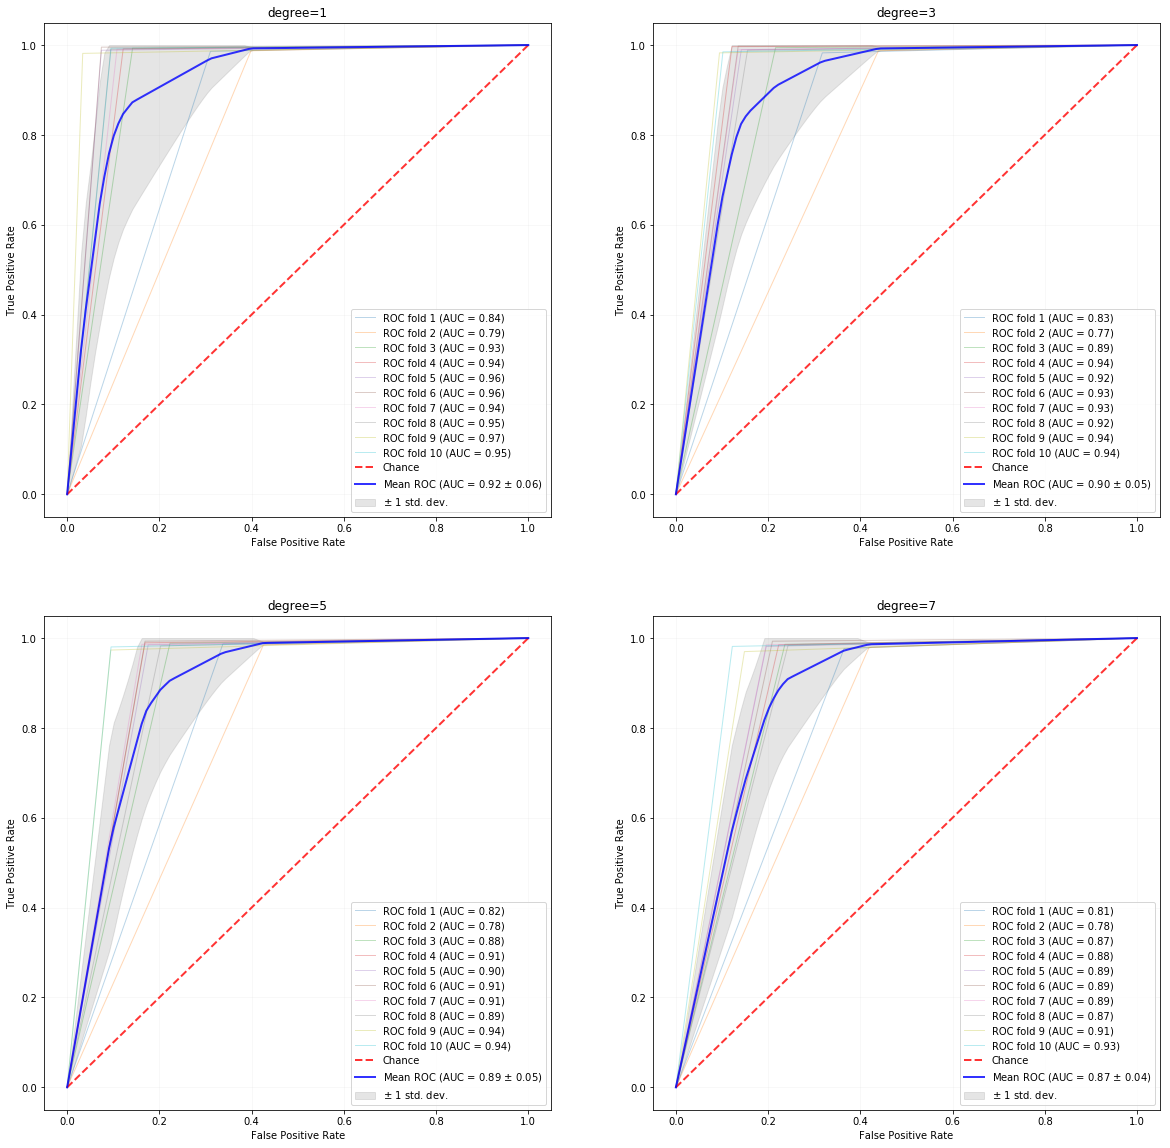

In [7]:
# Answer
# C, gamma
# from sklearn.model_selection import ****

# Use polynomial SVM
#svm_K = svm.SVC(kernel = 'poly', degree = 3)
#svm_K.fit(X_PCs, WBC_bool)
plt.figure(figsize=(20,20))
num_degree_array = np.array([1,3,5,7])
for num in range(0, 4):
    # Set up Stratified K-folds cross validation
    cv = StratifiedKFold(n_splits=10)
    mean_fpr = np.linspace(0, 1, 100)
    svm_K = svm.SVC(kernel = 'poly', degree = num_degree_array[num])
    tprs, aucs = [],[]
    i = 0
    plt.subplot(221+num)
    
    # Cross-validate
    for train, test in cv.split(X_PCs, WBC_bool):
        X = X_PCs
        y = WBC_bool
        model = svm_K.fit(X[train], y[train])
        probs = model.predict(X[test])
        # Compute ROC curve and area the curve

        # False Positive Rate, True Positive Rate, Thresholds
        FPR, TPR, thresholds = roc_curve(y[test], probs)
        tprs.append(interp(mean_fpr, FPR, TPR))
        tprs[-1][0] = 0.0
        roc_auc = auc(FPR, TPR)
        aucs.append(roc_auc)
        plt.plot(FPR, TPR, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
        i +=1

    # Plot Chance line
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                 label='Chance', alpha=.8)

    # Plot TPR and AUC means
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Shade 1 std. dev.
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('degree=%1.0f' % num_degree_array[num])
    plt.legend(loc="lower right")
    plt.grid(alpha=0.1)

### (7) Your experimental collaborator asks you to determine whether she can collect a fewer number of measurements (cells) and still obtain the same classification efficiency when building a new estimator. How might you determine this? Can she?

Use cross-validation with a lower number of folds. Lower number of folds will have fewer measurements. The classification efficiency will be determined with ROC curves.

### (8) What if you can change the numbers of individual cell types that you collect? Is the model you obtain sensitive to the number of cells in each group to the same extent?

To run SVM to classify different, classify one against all the other ones first, and do this for all the types. This method can account for more numbers of cell types.

### (9) Your collaborator collects completely new data and brings it to you for classification. You take your chosen optimal model from (7) and classify each cell. Would you expect your model to perform better, identically, or slightly worse than before? Why?

I will expect the model to perform slightly worse than before, since the model has not seen the new data before. A new model would better accomodate the new data since it was trained on it.